In [1]:
import re
from jiwer import wer

def get_par(path):
  f = open(path, encoding="utf-8")
  lignes  = f.readlines()
  f.close()
  liste_pars = []
  current_par = ""
  for l in lignes:
    if len(l)>3:
      current_par+=re.sub("\n", "", l)
    else:
      if len(current_par)>0:
        liste_pars.append(current_par)
        current_par = ""
  return liste_pars

def get_wer(fichier_base, fichier_corr):

    par_base = get_par(fichier_base)
    par_corr = get_par(fichier_corr)
    
    dic_diag = {"Idem":0, "Diff":[]}

    eval_paragraphs = []
    for i, par in enumerate(par_corr):
      VP, FP, FN = 0, 0, 0
      #print(par_base[i][:10])
      #print(par_corr[i][:10])
      #print("")
      mots_base = par_base[i].split()
      for j, mot_corr in enumerate(par.split()):
        if j>len(mots_base)-1:
          dic_diag["Diff"].append([mot_corr, ""])
          FN+=1
        elif mot_corr == mots_base[j]:
          dic_diag["Idem"]+=1
          VP+=1
        else:
          dic_diag["Diff"].append([mot_corr, mots_base[j]])
          FP+=1
      accuracy = VP/(VP+FP+FN) 
      WER = wer(par, par_base[i])
      eval_paragraphs.append([accuracy, WER])
    print(dic_diag["Idem"], "mots communs")
    print(len(dic_diag["Diff"]))
    
    liste_wer = []
    
    for i, x in enumerate(eval_paragraphs):
      accuracy, WER = x
      #print(x)
      liste_wer.append(x)
      score_cumul = round(accuracy+WER, 1)#est égal à 1 ou très proche sauf pb de tokenization
      if score_cumul>1.1 or score_cumul<0.9: #On a une distortion entre les deux
        words_corr = par_corr[i].split()
        for j, word_base in enumerate(par_base[i].split()):
          if j<len(words_corr):
            word_corr = words_corr[j]
          else:
            word_corr = "______"
          #if word_base!=word_corr:
            #print(f"{j}\t{word_base}\t{word_corr}")
    
    import json
    name_out = "errors.json"
    w = open(name_out, "w", encoding="utf-8")
    w.write(json.dumps(dic_diag["Diff"], indent=2, ensure_ascii=False))
    w.close()

    print(f"Erreurs : {name_out}")

    return liste_wer

In [7]:
fichier_auto = "Fichiers_txt/PERRROT75_correction.txt"
fichier_corr = "Fichiers_txt/PERRROT75CORR.txt"

l = get_wer(fichier_auto, fichier_corr)
wers = [x[1] for x in l]

2631 mots communs
1420
Erreurs : errors.json


In [8]:
fichier_base = "Fichiers_txt/PERRROT75.txt"
fichier_corr = "Fichiers_txt/PERRROT75CORR.txt"

l2 = get_wer(fichier_base, fichier_corr)

wers2 = [x[1] for x in l2]

3265 mots communs
786
Erreurs : errors.json


In [9]:
import numpy as np

In [10]:
print("Fichier corrigé automatiquement")
print("Moyenne des WER des paragraphes : %f" % np.mean(wers))
print("Ecart-type : %f" % np.nanstd(wers))
print("-"*10)
print("Fichier non corrigé")
print("Moyenne des WER des paragraphes : %f" % np.mean(wers2))
print("Ecart-type : %f" % np.nanstd(wers2))

Fichier corrigé automatiquement
Moyenne : 0.242374
Ecart-type : 0.275868
----------
Fichier non corrigé
Moyenne : 0.199208
Ecart-type : 0.284136


In [120]:
print(len(wers))

57


In [11]:
paliers = [0, 0.1, 0.25, 0.5, 0.75, 1]

def grouper(liste_wer, paliers):
    groupes = []

    for i in range(0, len(paliers)):
        groupes.append([])

    for el in liste_wer:
        for i in range(0, len(paliers)):
            if i < len(paliers)-1:
                if el >= paliers[i] and el < paliers[i+1]:
                    groupes[i].append(el)
            else:
                if el >= paliers[i]:
                    groupes[i].append(el)

    #print(groupes)
    repartition = [len(x) for x in groupes]
    #print(repartition)
    return repartition, groupes

def calculer_cumul(liste):
    cumuls = []
    c = 0
    for l in liste:
        c += l
        cumuls.append(c)
    #print(cumuls)
    return cumuls

In [12]:
repartition, groupes = grouper(wers, paliers)
repartition2, groupes2 = grouper(wers2, paliers)

cumuls = calculer_cumul(repartition)
cumuls2 = calculer_cumul(repartition2)

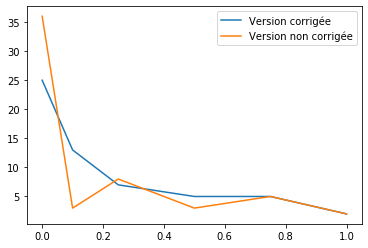

In [18]:
import matplotlib.pyplot as plt

plt.plot(paliers, repartition, label="Version corrigée")
plt.plot(paliers, repartition2, label = "Version non corrigée")
plt.legend()
plt.show()

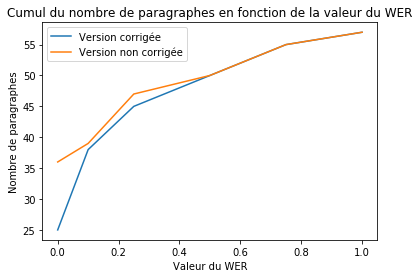

In [15]:
plt.plot(paliers, cumuls, label="Version corrigée")
plt.plot(paliers, cumuls2, label = "Version non corrigée")
plt.xlabel("Valeur du WER")
plt.ylabel("Nombre de paragraphes")
plt.title("Cumul du nombre de paragraphes en fonction de la valeur du WER")
plt.legend()
plt.show()

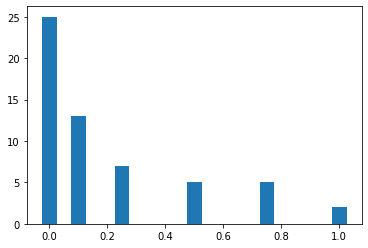

In [214]:
# peu significatif

plt.bar(paliers, repartition, width=0.05)
#plt.bar(paliers, repartition2, width=0.1)
plt.show()

In [19]:
# on pourrait rajouter le CER (caractère error rate)